In [1]:
import os
import sys

import geopandas as gpd
import pandas as pd
import numpy as np
from shapely import wkt

import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Guadalajara hexagons

In [2]:
schema = 'hexgrid'
folder = 'hexgrid_9_city_2020'
city = 'Queretaro'
type_area = 'urban'

query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" = \'{city}\' AND \"type\" = \'{type_area}\'"

hex_gdf = aup.gdf_from_query(query)
print(hex_gdf.shape)
hex_gdf.head(2)

(2826, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,894983d8997ffff,"POLYGON ((-100.45238 20.55939, -100.45114 20.5...",22006,Corregidora,Queretaro,urban
1,894983c3697ffff,"POLYGON ((-100.47848 20.52605, -100.47723 20.5...",22006,Corregidora,Queretaro,urban


In [3]:
hex_diss = hex_gdf.copy()
hex_diss = hex_diss.to_crs("EPSG:32613")
hex_diss = hex_diss.buffer(5).reset_index().rename(columns={0: "geometry"})
hex_diss = hex_diss.set_geometry("geometry")
hex_diss = hex_diss.to_crs("EPSG:4326")
hex_diss = hex_diss.dissolve()

## Uso de suelo

In [3]:
us_gdf = gpd.read_file('../data/processed/GDL_D07_Usos_de_Suelo_2011.shp')
print(us_gdf.shape)
us_gdf.head(2)

(289582, 4)


,LAYER,DISTRITO,SD,geometry
0,Sin actividad registrada,7,1,"POLYGON ((669128.755 2285711.511, 669087.663 2..."
1,Sin actividad registrada,7,1,"POLYGON ((670889.528 2285305.617, 670866.552 2..."


<AxesSubplot: >

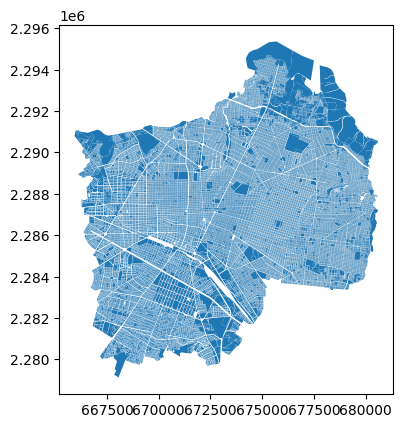

In [4]:
us_gdf.plot()

## Edificaciones

### Preprocessing

In [18]:
ed_gdf = pd.read_csv('../../../data/raw/85d_buildings.csv')
print(ed_gdf.shape)
ed_gdf.head(2)

(38408563, 6)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code
0,19.449756,-98.106921,143.5921,0.8962,"POLYGON((-98.1068452418125 19.449729513805, -9...",76F3CVXV+W648
1,18.324542,-100.276654,65.9477,0.8332,"POLYGON((-100.276594956198 18.3245378927072, -...",75CX8PFF+R89J


In [19]:
ed_gdf['geometry'] = ed_gdf['geometry'].apply(wkt.loads)
ed_gdf = gpd.GeoDataFrame(ed_gdf, crs='epsg:4326')

In [20]:
ed_clip = gpd.clip(ed_gdf, hex_diss)
ed_clip = list(ed_clip.full_plus_code.unique())

In [21]:
bld_qro = ed_gdf.loc[(ed_gdf.full_plus_code).isin(ed_clip)]
print(bld_qro.shape)
bld_qro.head(2)

(781306, 6)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code
23,20.623721,-100.416809,44.7050,0.7026,"POLYGON ((-100.41678 20.62368, -100.4168 20.62...",75GXJHFM+F7PR
52,20.553461,-100.389767,87.0057,0.8101,"POLYGON ((-100.38973 20.55351, -100.38983 20.5...",75GXHJ36+93QF


In [22]:
del ed_clip
del ed_gdf

### Read file

In [4]:
# bld_qro.to_file('../../../data/processed/Distrito_QRO/buildings_queretaro.geojson')
bld_qro = gpd.read_file('../../../data/processed/Distrito_QRO/buildings_queretaro.geojson')

## Manzanas

In [5]:
poly_wkt = hex_diss.geometry.to_wkt()[0]

In [6]:
schema = 'marco'
table = 'mza_2020'

query = f"SELECT * FROM {schema}.{table} WHERE ST_Intersects(geometry, 'SRID=4326;{poly_wkt}')"
mnz_gdf = aup.gdf_from_query(query, geometry_col='geometry')
print(mnz_gdf.shape)
mnz_gdf.head(4)

(19849, 9)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
0,2201105180119028,22,011,0518,0119,028,Rural,Típica,"POLYGON ((-100.28973 20.59585, -100.2899 20.59..."
1,220110479080A036,22,011,0479,080A,036,Urbana,Típica,"POLYGON ((-100.29095 20.59109, -100.29094 20.5..."
2,220110479080A015,22,011,0479,080A,015,Urbana,Típica,"POLYGON ((-100.29092 20.5916, -100.29092 20.59..."
3,220110479080A039,22,011,0479,080A,039,Urbana,Típica,"POLYGON ((-100.29058 20.59098, -100.29057 20.5..."


## Intersecciones

In [7]:
nodes = gpd.read_file('../../../data/processed/Distrito_QRO/nodes_qro.geojson')
print(nodes.shape)
nodes.head(2)

Skipping field osmid: unsupported OGR type: 5


(35950, 6)


,streets_count,x,y,street_count,cluster,geometry
0,3.0,334645.100188,2.292054e+06,3,NaN,POINT (334645.1 2292054.112)
1,3.0,334676.442572,2.292063e+06,3,NaN,POINT (334676.443 2292063.465)


## Vialidades

In [8]:
edges = gpd.read_file('../../../data/processed/Distrito_QRO/edges_qro.geojson')
edges = edges.explode()
print(edges.shape)
edges.head(4)

(59031, 5)


,u,v,key,length,geometry
0,33464510229205411,33467644229206346,0,32.708216,"LINESTRING (334645.1 2292054.112, 334676.443 2..."
1,33464510229205411,33484542229215277,0,360.491004,"LINESTRING (334645.1 2292054.112, 334643.239 2..."
2,33467644229206346,33474525229209792,0,80.832452,"LINESTRING (334676.443 2292063.465, 334677.025..."
3,33467644229206346,33474525229209792,1,103.769233,"LINESTRING (334676.443 2292063.465, 334676.632..."


## Space syntax

In [9]:
ss_gdf = gpd.read_file('../data/processed/VialidadesAMG_AngularChoice_INEGI19_UTM_v3.shp')
print(ss_gdf.shape)
ss_gdf.head(2)

DataSourceError: ../data/processed/VialidadesAMG_AngularChoice_INEGI19_UTM_v3.shp: No such file or directory

## Spatial anaylsis

### Land use

In [11]:
us_gdf = us_gdf.to_crs("EPSG:4326")

In [12]:
us_hex = us_gdf.overlay(hex_gdf, how='intersection')
us_hex['area_ha_us'] = us_hex.to_crs("EPSG:32613").area/10000
print(us_hex.shape)
us_hex.head(2)

(319062, 10)


,LAYER,DISTRITO,SD,hex_id_9,CVEGEO,NOMGEO,city,type,geometry,area_ha_us
0,Sin actividad registrada,7,1,89498c96c73ffff,14039,Guadalajara,Guadalajara,urban,"POLYGON ((-103.37682 20.66296, -103.37686 20.6...",0.039996
1,Comercio y Servicios,7,1,89498c96c73ffff,14039,Guadalajara,Guadalajara,urban,"POLYGON ((-103.37735 20.66115, -103.37775 20.6...",0.110757


In [13]:
us_area = us_hex.groupby(['hex_id_9']).sum()
us_area = us_area.reset_index()[['hex_id_9','area_ha_us']]
us_area = us_area.rename(columns={'area_ha_us':'area_ha'})
us_area.head(2)

/tmp/ipykernel_74187/2901893028.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  us_area = us_hex.groupby(['hex_id_9']).sum()


,hex_id_9,area_ha
0,89498c94003ffff,8.119861
1,89498c94007ffff,8.173849


In [14]:
us_hex = us_hex.groupby(['hex_id_9','LAYER']).sum()
us_hex = us_hex.reset_index()
us_hex = us_hex.merge(us_area[['hex_id_9','area_ha']], on='hex_id_9')
print(us_hex.shape)
us_hex.head(2)

(5819, 6)


/tmp/ipykernel_74187/1672011573.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  us_hex = us_hex.groupby(['hex_id_9','LAYER']).sum()


,hex_id_9,LAYER,DISTRITO,SD,area_ha_us,area_ha
0,89498c94003ffff,Comercio y Servicios,285,57,0.945623,8.119861
1,89498c94003ffff,Espacios Abiertos,5,1,0.027123,8.119861


In [15]:
us_hex['pct'] = us_hex['area_ha_us'] / us_hex['area_ha']
us_hex = us_hex[['hex_id_9','LAYER','pct']]
us_hex.head(2)

,hex_id_9,LAYER,pct
0,89498c94003ffff,Comercio y Servicios,0.116458
1,89498c94003ffff,Espacios Abiertos,0.003340


In [16]:
us_hex = pd.pivot_table(us_hex,'pct',index='hex_id_9', columns='LAYER').reset_index()
us_hex.index.names = ['']
print(us_hex.shape)
us_hex.head(2)

(1211, 10)


LAYER,hex_id_9,Agropecuario,Baldios,Comercio y Servicios,Equipamiento,Espacios Abiertos,Habitacional,Industrial,Infraestructura,Sin actividad registrada
,,,,,,,,,,
0,89498c94003ffff,NaN,NaN,0.116458,NaN,0.003340,0.878489,NaN,NaN,0.001713
1,89498c94007ffff,NaN,NaN,0.163763,0.009889,0.005392,0.799105,0.019287,NaN,0.002563


In [17]:
us_hex = us_hex.fillna(0)

### Open space

In [12]:
mnz_diff = mnz_gdf.overlay(bld_qro, how='difference')
print(mnz_diff.shape)
mnz_diff.head(2)

(19849, 9)


/home/edgaregurrola/.cache/pypoetry/virtualenvs/aup-qDsIK5d5-py3.13/lib/python3.13/site-packages/geopandas/geodataframe.py:2675: UserWarning: `keep_geom_type=True` in overlay resulted in 335 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
0,2201105180119028,22,011,0518,0119,028,Rural,Típica,"POLYGON ((-100.2899 20.596, -100.28983 20.5960..."
1,220110479080A036,22,011,0479,080A,036,Urbana,Típica,"POLYGON ((-100.29055 20.59122, -100.29056 20.5..."


<Axes: >

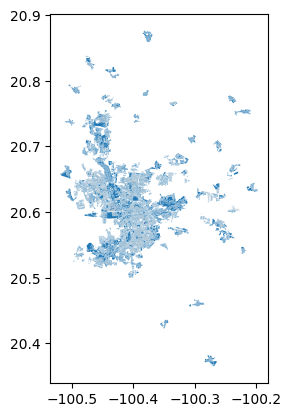

In [13]:
mnz_diff.plot()

In [14]:
del bld_qro

1. Calcular área 2. Extraer centroides 3. Intersección por localización

In [15]:
mnz_diff_hex = mnz_diff.overlay(hex_gdf, how='intersection')
mnz_diff_hex = mnz_diff_hex.explode()

/home/edgaregurrola/.cache/pypoetry/virtualenvs/aup-qDsIK5d5-py3.13/lib/python3.13/site-packages/geopandas/geodataframe.py:2675: UserWarning: `keep_geom_type=True` in overlay resulted in 68 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


In [16]:
mnz_diff_hex['area_dif_ha'] = mnz_diff_hex.to_crs("EPSG:32614").area/10000
print(mnz_diff_hex.shape)
mnz_diff_hex.head(2)

(97701, 15)


,CVEGEO_1,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,hex_id_9,CVEGEO_2,NOMGEO,city,type,geometry,area_dif_ha
0,220110479080A036,22,011,0479,080A,036,Urbana,Típica,89498236b03ffff,22011,El Marqués,Queretaro,urban,"POLYGON ((-100.29056 20.59129, -100.29064 20.5...",0.035793
1,220110479080A015,22,011,0479,080A,015,Urbana,Típica,89498236b07ffff,22011,El Marqués,Queretaro,urban,"POLYGON ((-100.29092 20.5916, -100.29091 20.59...",0.002366


In [17]:
mnz_hex = mnz_gdf.overlay(hex_gdf, how='intersection')
mnz_hex = mnz_hex.explode()

In [18]:
mnz_hex['area_tot_ha'] = mnz_hex.to_crs("EPSG:32614").area/10000
print(mnz_hex.shape)
mnz_hex.head(2)

(35118, 15)


,CVEGEO_1,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,hex_id_9,CVEGEO_2,NOMGEO,city,type,geometry,area_tot_ha
0,220110479080A036,22,011,0479,080A,036,Urbana,Típica,89498236b03ffff,22011,El Marqués,Queretaro,urban,"POLYGON ((-100.29094 20.59124, -100.29051 20.5...",0.068991
1,220110479080A015,22,011,0479,080A,015,Urbana,Típica,89498236b07ffff,22011,El Marqués,Queretaro,urban,"POLYGON ((-100.29092 20.5916, -100.29091 20.59...",0.037469


In [19]:
mnz_hex = mnz_hex[['hex_id_9','area_tot_ha']].groupby('hex_id_9').sum()
mnz_diff_hex = mnz_diff_hex.groupby('hex_id_9').sum(numeric_only=True)
mnz_hex = mnz_hex.reset_index()
mnz_diff_hex = mnz_diff_hex.reset_index()
mnz_hex = mnz_hex.merge(mnz_diff_hex, on='hex_id_9')

In [20]:
mnz_hex['pct'] = mnz_hex['area_dif_ha'] / mnz_hex['area_tot_ha']
mnz_hex.head(4)

,hex_id_9,area_tot_ha,area_dif_ha,pct
0,8949822402fffff,2.377252,2.156330,0.907068
1,89498224103ffff,6.683817,5.572192,0.833684
2,89498224107ffff,2.894334,2.617256,0.904269
3,8949822410bffff,11.018867,8.853284,0.803466


In [21]:
mnz_hex = mnz_hex[['hex_id_9','pct']]

### Number of intersections

In [22]:
nodes = nodes.to_crs("EPSG:4326")

In [23]:
nodes_hex = nodes.overlay(hex_gdf, how='intersection')
print(nodes_hex.shape)
nodes_hex.head(4)

(29330, 11)


,streets_count,x,y,street_count,cluster,hex_id_9,CVEGEO,NOMGEO,city,type,geometry
0,3.0,341826.185733,2.284851e+06,3,NaN,894983c1d7bffff,22014,Querétaro,Queretaro,urban,POINT (-100.51836 20.65631)
1,3.0,341890.954152,2.285075e+06,5,270.0,894983c1d7bffff,22014,Querétaro,Queretaro,urban,POINT (-100.51776 20.65834)
2,3.0,341854.395673,2.284909e+06,3,NaN,894983c1d7bffff,22014,Querétaro,Queretaro,urban,POINT (-100.5181 20.65684)
3,3.0,343102.403837,2.284297e+06,3,NaN,894983c1883ffff,22014,Querétaro,Queretaro,urban,POINT (-100.50606 20.65142)


In [24]:
nodes_hex = nodes_hex.groupby('hex_id_9').count().reset_index()
nodes_hex = nodes_hex[['hex_id_9','CVEGEO']].rename(columns={'CVEGEO':'number_intersections'})
nodes_hex.head(4)

,hex_id_9,number_intersections
0,8949822402fffff,3
1,89498224103ffff,8
2,89498224107ffff,5
3,8949822410bffff,6


### Street area

In [25]:
edges = edges.to_crs("EPSG:4326")
edges_hex = edges.overlay(hex_gdf, how='intersection')
edges_hex['len_km'] = edges_hex.to_crs("EPSG:32613").length / 1000
edges_hex = edges_hex.groupby('hex_id_9').sum(numeric_only =True)
edges_hex = edges_hex.reset_index()
edges_hex = edges_hex[['hex_id_9','len_km']]
print(edges_hex.shape)
edges_hex.head(2)

(2786, 2)


,hex_id_9,len_km
0,8949822402fffff,1.085651
1,89498224103ffff,1.500347


In [26]:
tmp_hex = hex_gdf.overlay(mnz_gdf, how='difference')
tmp_hex['area_ha'] = tmp_hex.to_crs("EPSG:32613").area / 10000
tmp_hex = tmp_hex[['hex_id_9','area_ha']]
print(tmp_hex.shape)
tmp_hex.head(2)

(2810, 2)


,hex_id_9,area_ha
0,894983d8997ffff,6.483568
1,894983c3697ffff,10.549036


In [27]:
edges_hex = edges_hex.merge(tmp_hex, on='hex_id_9')
edges_hex['street_dens'] = edges_hex['len_km'] / edges_hex['area_ha']
edges_hex = edges_hex[['hex_id_9','street_dens']]
edges_hex.head(4)

,hex_id_9,street_dens
0,8949822402fffff,0.109048
1,89498224103ffff,0.266709
2,89498224107ffff,0.103757
3,8949822410bffff,1.118360


### Space syntax

In [33]:
ss_gdf = ss_gdf.to_crs("EPSG:4326")
ss_gdf = ss_gdf[['NI_sl500','geometry']]
ss_hex = ss_gdf.overlay(hex_gdf, how='intersection')
print(ss_hex.shape)
ss_hex.head(2)

(54105, 7)


,NI_sl500,hex_id_9,CVEGEO,NOMGEO,city,type,geometry
0,0.865135,8949ab4b6dbffff,14039,Guadalajara,Guadalajara,urban,"LINESTRING (-103.38698 20.71018, -103.38579 20..."
1,0.807797,8949ab4b6dbffff,14039,Guadalajara,Guadalajara,urban,"LINESTRING (-103.38834 20.70997, -103.38879 20..."


In [34]:
ss_hex['length_km'] = ss_hex.to_crs("EPSG:32613").length / 1000
ss_tot = ss_hex.groupby('hex_id_9').sum()
ss_tot = ss_tot.reset_index()
ss_tot = ss_tot[['hex_id_9','length_km']]
ss_tot = ss_tot.rename(columns={'length_km':'length_tot_km'})
ss_tot.head(4)

/tmp/ipykernel_74187/3212174632.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ss_tot = ss_hex.groupby('hex_id_9').sum()


,hex_id_9,length_tot_km
0,89498c94003ffff,2.507217
1,89498c94007ffff,2.400254
2,89498c9400bffff,2.633676
3,89498c9400fffff,2.646655


In [35]:
ss_hex = ss_hex.merge(ss_tot, on='hex_id_9')
ss_hex['pct_ss'] = ss_hex['length_km'] / ss_hex['length_tot_km']
ss_hex['wgt_ss'] = ss_hex['pct_ss'] * ss_hex['NI_sl500']
ss_hex = ss_hex.groupby('hex_id_9').sum()
ss_hex = ss_hex.reset_index()
ss_hex = ss_hex[['hex_id_9','wgt_ss']]
ss_hex.head(2)

/tmp/ipykernel_74187/660076386.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ss_hex = ss_hex.groupby('hex_id_9').sum()


,hex_id_9,wgt_ss
0,89498c94003ffff,1.147223
1,89498c94007ffff,1.049694


## Hexagon data

In [28]:
# hex_gdf = hex_gdf.merge(us_hex, on='hex_id_9')
hex_gdf = hex_gdf.merge(mnz_hex, on='hex_id_9')
hex_gdf = hex_gdf.merge(edges_hex, on='hex_id_9')
# hex_gdf = hex_gdf.merge(ss_hex, on='hex_id_9')
print(hex_gdf.shape)
hex_gdf.head(4)

(2747, 8)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,pct,street_dens
0,894983d8997ffff,"POLYGON ((-100.45238 20.55939, -100.45114 20.5...",22006,Corregidora,Queretaro,urban,0.515703,0.483324
1,894983c3697ffff,"POLYGON ((-100.47848 20.52605, -100.47723 20.5...",22006,Corregidora,Queretaro,urban,0.512608,0.149998
2,894983d88bbffff,"POLYGON ((-100.43124 20.55215, -100.42999 20.5...",22006,Corregidora,Queretaro,urban,0.822404,0.851537
3,894983c1687ffff,"POLYGON ((-100.44908 20.58645, -100.44784 20.5...",22006,Corregidora,Queretaro,urban,0.629915,0.275884


<Axes: >

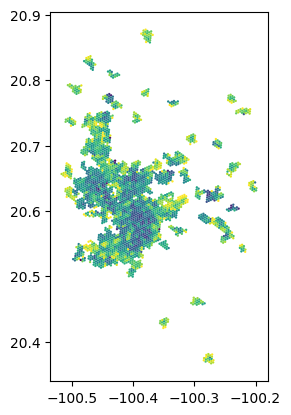

In [29]:
hex_gdf.plot('pct')

<Axes: >

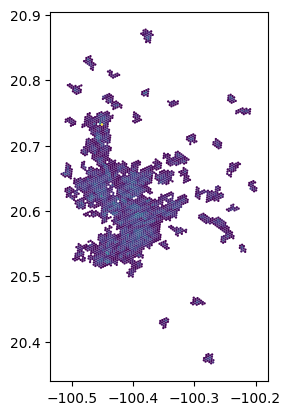

In [30]:
hex_gdf.plot('street_dens')

<AxesSubplot: >

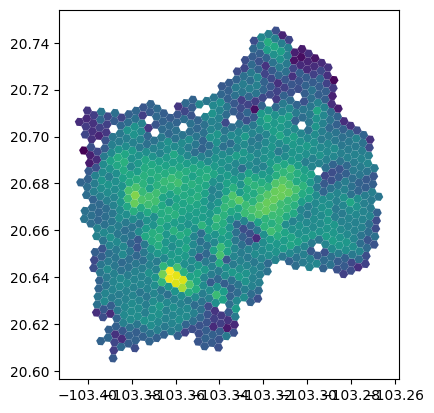

In [41]:
hex_gdf.plot('wgt_ss')

In [31]:
hex_gdf.to_file('../../../data/processed/Distrito_QRO/hex_urban_structure.geojson')